# I Packages and Data Imports

In [1]:
# Packages import

import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import glob
import random
import pandas as pd
import pywt # Pywavelet to express images in sparse wavelet basis
from pywt import wavedec, dwt 
from sporco.admm import tvl1, bpdn # Sparse optimization package 
from skimage.measure import compare_ssim as ssim # Structural Similarity Index between images

In [2]:
# Data import for MovedObject Dataset

x_train = []
x_test = []

for image_path in glob.glob("train_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L") # Reading in greyscale to speed up optimization
    image = misc.imresize(image, 0.6) # Resize image 
    image = image / 255 # Normalizing image 
    x_train.append(image)

for image_path in glob.glob("test_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L")
    image = misc.imresize(image, 0.6)
    image = image / 255
    x_test.append(image)

x_train = np.stack(x_train)
x_test = np.stack(x_test)

# Data import for WavingTrees Dataset

x_train_2 = []
x_test_2 = []

for image_path in glob.glob("train_dataset_2/*.bmp"):
    image = misc.imread(image_path, mode = "L") # Reading in greyscale to speed up optimization
    image = misc.imresize(image, 0.4) # Resize image 
    image = image / 255 # Normalizing image 
    x_train_2.append(image)

for image_path in glob.glob("test_dataset_2/*.bmp"):
    image = misc.imread(image_path, mode = "L")
    image = misc.imresize(image, 0.4)
    image = image / 255
    x_test_2.append(image)

x_train_2 = np.stack(x_train_2)
x_test_2 = np.stack(x_test_2)

/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


# II Presentation of the Object Detector Class

In [36]:
class Object_Detector(object):
    """
    Implementation of the Compressive Sensing for Background Substraction algorithm reframed
    as an object detector class. All the hyperparameters were found using cross-validation. All
    the methods are commented.
    
    Arguments:
    im_w, im_h -- the image dimensions
    """

    def __init__(self, im_w, im_h, r=0.8, lmbda1=0.1, lmbda2=8e-1, alpha=0.5, 
                 gamma=0.1):
        """
        Initialization of the class.
        
        Arguments:
        r -- measurement rate (M / N)
        lambda 1 -- the BPDN L1 regularization hyperparameter
        lambda 2 -- the TV L1 regularization hyperparameter
        alpha -- the adaptation of the background constraint first learning rate
        gamma -- the adaptation of the background constraint second learning rate
        """
        
        self.im_w = im_w
        self.im_h = im_h
        self.N = int(self.im_w * self.im_h)
        self.r = r
        self.M = int(self.N * self.r)
        self.A = self.random_measurement_matrices(self.M, self.N)[1]
        self.phi = self.random_measurement_matrices(self.M, self.N)[0]
        self.lmbda1 = lmbda1
        self.lmbda2 = lmbda2
        self.alpha = alpha
        self.gamma = gamma
    
    def wavelet_dec(self, sig, threshold=1):
        """
        Takes a signal as input, performs a single level Discrete Wavelet Transform of it and 
        sparsifies it with hard thresholding. Psi sparse basis in the article.

        Arguments:
        sig -- the signal to be sparsified (rows of the matrix Phi)
        threshold -- the data values where their absolute value is less than 
        the value param are replaced with substitute (default=0)

        Returns:
        sparse_sig -- signal expressed in a sparse haar wavelet basis 
        """

        coeffs = np.concatenate(dwt(sig, 'haar')) # Details and Approximation coefficients 
        sparse_sig = pywt.threshold(coeffs, threshold, 'hard') # Thresholding to sparsify

        return sparse_sig

    def random_measurement_matrices(self, M, N, rand_type = "gauss"):
        """
        Takes the measurement size M and the vector size of the image N and returns the 
        required matrices
        
        Arguments:
        M -- measurement size
        N -- the total size of the image (nx x ny)
        rand_type -- type of random distribution for the measurement matrix

        Returns:
        A -- matrix of dimension (M x N), corresponds to Phi * Psi in the article
        phi -- the measurement matrix
        """
        
        np.random.seed(10) # Setting seed for reproductibility
        if rand_type == "student":
            phi = np.random.standard_t(power, size=(M, N))
        else:
            phi = np.random.randn(M, N)
            
        A = np.apply_along_axis(self.wavelet_dec, axis=1, arr=phi) # Equivalent to the Phi * Psi product
    
        return phi, A
        
    
    def compressive_measurements(self, x):
        """
        Takes an image and the compression rate as argument, returns a dictionnary

        Arguments:
        x -- the original image

        Returns: 
        y -- vector of dimension (M (= r * N) x 1)
        """
        x = x.reshape(1, -1).T # Reshape the image to be a (N x 1) vector
        y =  np.dot(self.A, x) # Compressive samples generation 

        return y
    
    def signal_reconstruction(self, y):
        """
        Signal recovery using the Basis Pursuit Denoising (BPDN) and the L1
        Total Variation (TV) denoising algorithm from the SPORCO package

        Arguments:
        y -- the measurement vector of size (M x 1)

        Returns:
        x_hat -- the recovered signal from BPDN optimization (N x 1). This corresponds to 
        theta_hat in the article. We decided to work directly with theta_hat to recover 
        the images given the closeness of it with the original signal/image. It also 
        avoids us to do one more linear transformation (mainly x_hat = theta_hat * Psi).
        x_hat_rshp -- the reshaped recovered signal of size (nx x ny)
        x_hat_tv -- the denoised recovered signal of size (nx x ny)  
        """
        
        # Run BPDN optimisation
        opt1 = bpdn.BPDN.Options()
        x = bpdn.BPDN(self.A, y, self.lmbda1, opt1)
        x_hat = x.solve() 
        x_hat_rshp = x_hat.reshape(self.im_w, self.im_h) # Reshape for visualization
        opt2 = tvl1.TVL1Denoise.Options()

        # Initialise and run TVL1Denoise object
        b1 = tvl1.TVL1Denoise(x_hat_rshp, self.lmbda2, opt2)
        x_hat_tv = b1.solve()

        return x_hat, x_hat_rshp, x_hat_tv
    
    def fit(self, x_train):
        """
        Fit the model to the training background data using maximum likelihood estimation.
        Corresponds to the section 3.2 and 3.3 of the article. 
        
        Arguments:
        x_train -- the background training images
        
        Returns:
        x_b -- the mean of the background training images
        y_b -- the mean of the corresponding random measurement
        mu_bg -- the mean of the fitted Gaussian distribution
        sigma_bg -- the variance of the fitted Gaussian distribution
        """
        
        x_b = np.mean(x_train, axis=0)
        y_b = self.compressive_measurements(x_b)
        y_train = [self.compressive_measurements(x) for x in x_train]
        l = [np.log(np.sum((yi - y_b) ** 2)) for yi in y_train]
        mu_bg = np.mean(l)
        sigma_bg = (1 / (len(l) - 1)) * np.sum((l - mu_bg) ** 2)
        model = {"x_b" :x_b, "y_b" : y_b, "mu_bg" : mu_bg, "sigma_bg" : sigma_bg}
        
        return model
    
    def predict(self, x_test, model, rec=False, backup=0, c=3, diff=False, verbose=False):
        """
        Predict if there is an innovation on the test image using the CS background substraction
        algorithm and the adaptation of the background constraint. 
        
        Arguments:
        x_test -- the test images
        model -- the fitted model 
        rec (boolean) -- if True, the updated background, the test image and the reconstructed 
        difference images are shown
        backup (int) -- if 0, there is no background adaptation
                        if 1, the (9) background adaptation is integrated
                        if 2, the (10) background adaptation is integrated
        """
        
        mu_bg = model["mu_bg"]
        sigma_bg = model["sigma_bg"]
        y_b = model["y_b"]
        x_b = model["x_b"]
        xb_hat, xb_hat_rshp, xb_hat_tv = self.signal_reconstruction(y_b)
        
        # Testing if the test image has a new object
        self.distance = []
        for i, xtest in enumerate(x_test):
            y_t = self.compressive_measurements(xtest)  
            y_d = y_t - y_b
            dist = np.log(np.sum(y_d ** 2))
            d = np.abs(dist - mu_bg)
            self.distance.append(d)
            if diff:
                print(d)
            if  d >= c * np.sqrt(sigma_bg) and verbose:
                print("Object Detected!") 
            xd_hat, xd_hat_rshp, xd_hat_tv = self.signal_reconstruction(y_d)
            y_d_hat = np.dot(self.A, xd_hat)
            
            if backup == 1:
                y_b_new = self.background_update_1(y_b, y_t, y_d_hat)
                y_b = y_b_new
                xb_hat, xb_hat_rshp, xb_hat_tv = self.signal_reconstruction(y_b)
                
            if backup == 2:
                if i == 0:
                    y_ma = y_t
                bkup = self.background_update_2(y_b, y_t, y_ma)
                y_b_new = bkup[0]
                y_ma_new = bkup[1]
                y_b = y_b_new
                y_ma = y_ma_new
                xb_hat, xb_hat_rshp, xb_hat_tv = self.signal_reconstruction(y_b)
                
            if rec:
                fig = plt.figure(figsize=(8, 8))
                ax1 = plt.subplot(222)
                ax1.set_title("Background Image")
                ax1.imshow(xb_hat_tv)
                ax1.axis("off")
                ax2 = plt.subplot(223)
                ax2.set_title("Test Image")
                ax2.imshow(xtest)
                ax2.axis("off")
                ax3 = plt.subplot(224)
                ax3.set_title("Difference Image")
                ax3.imshow(xd_hat_tv)
                ax3.axis("off")
                plt.show()

    def background_update_1(self, y_b, y_t, y_d_hat):
        """
        Implementation of the (9) equation of the article. 
        
        Arguments:
        y_b -- the current background compressive measurements' mean
        y_t -- the current test compressive measurement image
        y_d_hat -- the reconstructed difference compressive measurement
        
        Returns:
        y_b_new -- the updated background compressive measurements' mean
        """
        y_b_new = self.alpha * (y_t - y_d_hat) + (1 - self.alpha) * y_b
        return y_b_new
    
    def background_update_2(self, y_b, y_t, y_ma):
        """
        Implementation of the (10) equation of the article. 
        
        Arguments:
        y_b -- the current background compressive measurements' mean
        y_t -- the current test compressive measurement image
        y_ma -- current moving average
        
        Returns:
        y_b_new -- the updated background compressive measurements' mean
        y_ma_new -- the updated moving average
        """
    
        y_ma_new = self.gamma * y_t + (1 - self.gamma) * y_ma
        xma_hat, xma_hat_rshp, xma_hat_tv = self.signal_reconstruction(y_ma_new)
        y_e_hat = np.dot(self.A, xma_hat)        
        y_b_new = self.alpha * (y_t - y_e_hat) + (1 - self.alpha) * y_b
        
        return y_b_new, y_ma_new
    
    @ staticmethod
    def mse(imageA, imageB):
        """
        Returns the Mean Squared Error of two images pixelwise
        """

        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])

        return err

    @ staticmethod
    def compare_images(imageA, imageB, title):
        """
        Compare two images using the MSE and the more advanced 
        skimage structural similarity index. 
        """

        m = Object_Detector.mse(imageA, imageB) # between 0 and +infty (0 best)
        s = ssim(imageA, imageB) # between -1 and 1 (1 best)

        # setup the figure
        fig = plt.figure()
        plt.title(title)
        plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
        plt.axis("off")

        # show first image
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(imageA)
        plt.axis("off")

        # show the second image
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(imageB)
        plt.axis("off")

        # show the images
        plt.show()

# III Image reconstruction with different measurement rate

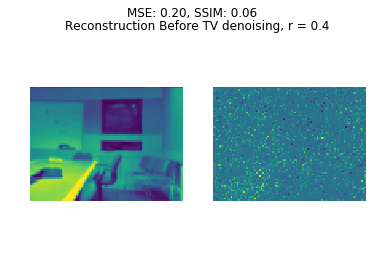

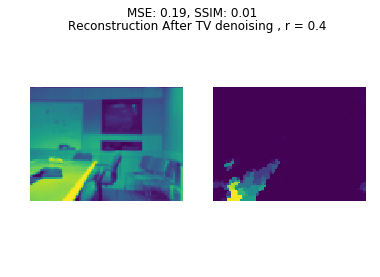

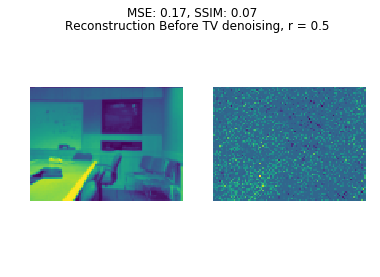

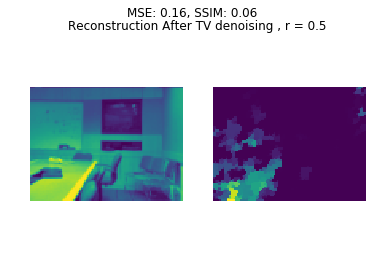

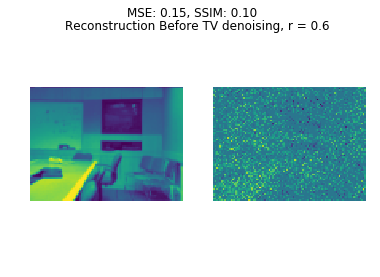

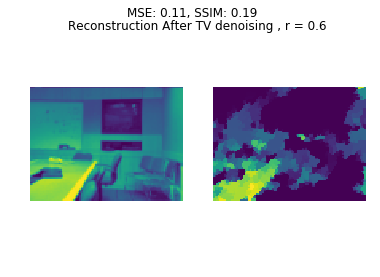

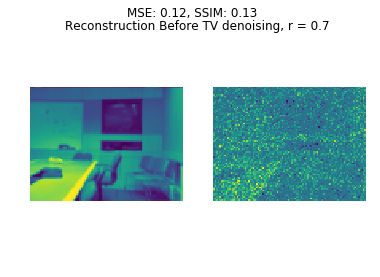

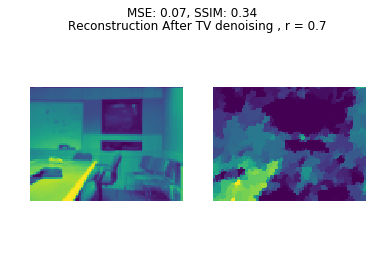

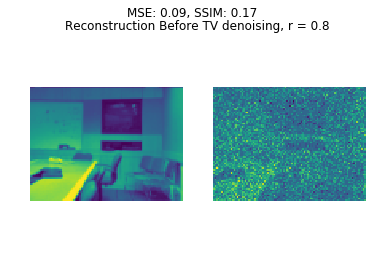

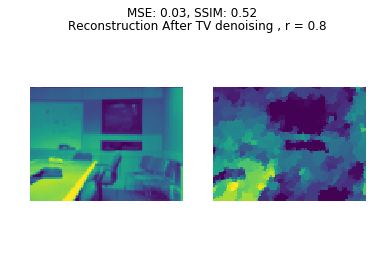

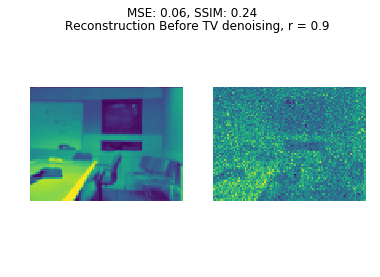

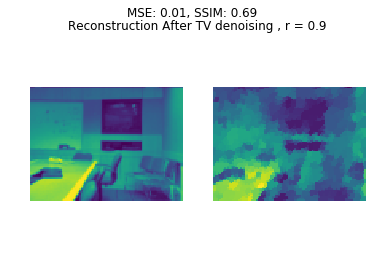

In [10]:
img_w, img_h = x_train[0].shape
M = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for r in M:
    cls = Object_Detector(img_w, img_h, r=r)
    y = cls.compressive_measurements(x_train[0])
    x_hat, x_hat_rshp, x_hat_tv = cls.signal_reconstruction(y)
    cls.compare_images(x_train[0], x_hat_rshp, "Reconstruction Before TV denoising, r = {}".format(r))
    cls.compare_images(x_train[0], x_hat_tv, "Reconstruction After TV denoising , r = {}".format(r))

Though the reconstruction of the image seems to be good only after 70%, we obtain good detection results with measurement rates far lower. 

# IV Background Substraction Model on the MovedObject Dataset

[ 527  733 1032 1097  256]
Measurement rate of 50%


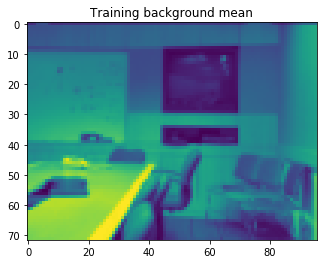

Object Detected!


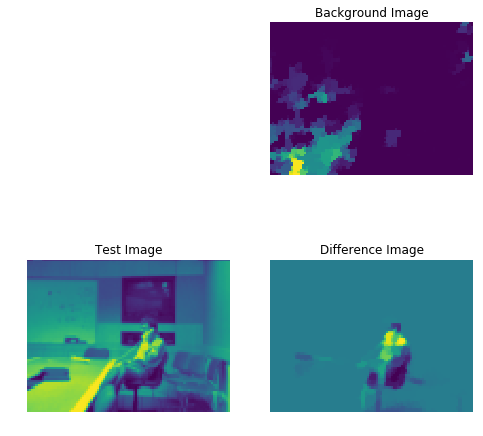

Object Detected!


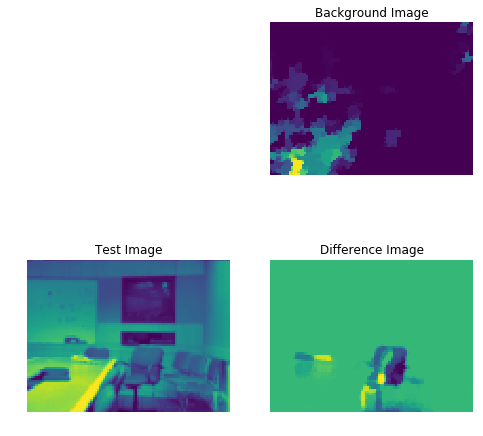

Object Detected!


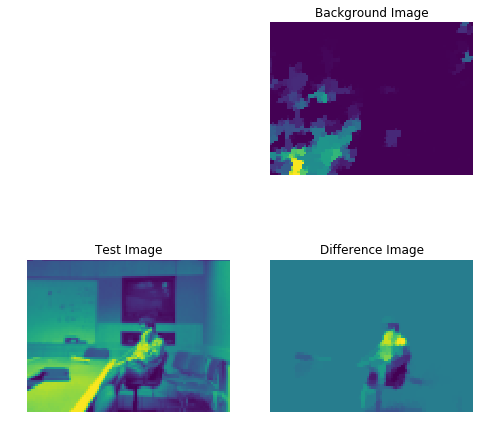

Object Detected!


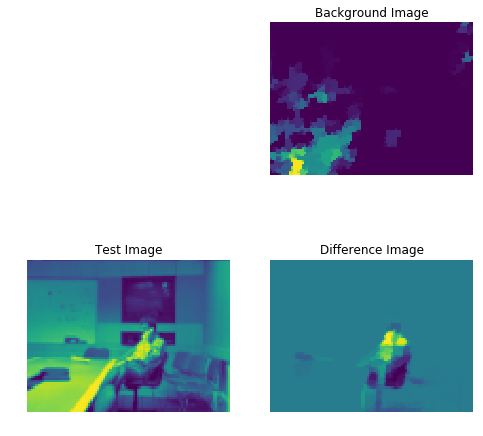

Object Detected!


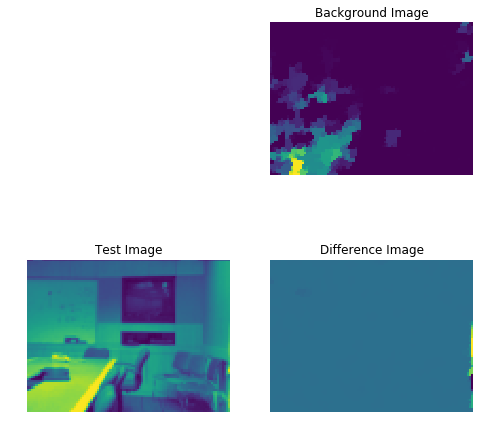

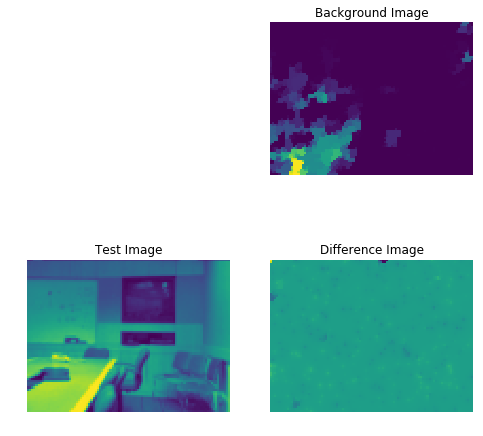

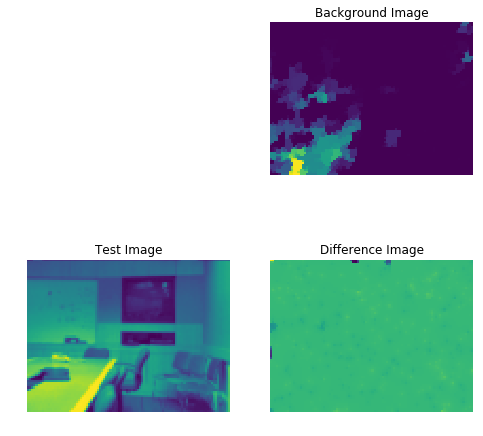

Measurement rate of 10%


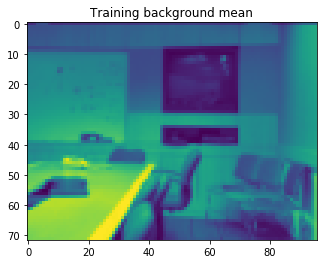

Object Detected!


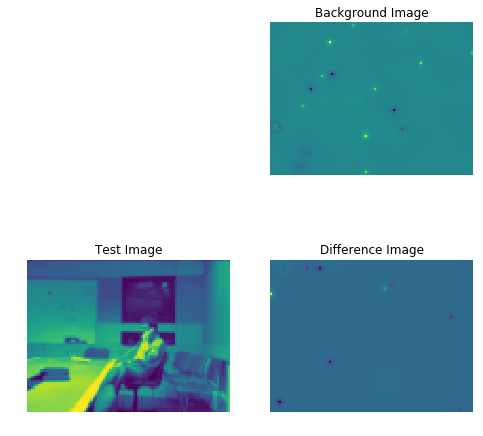

Object Detected!


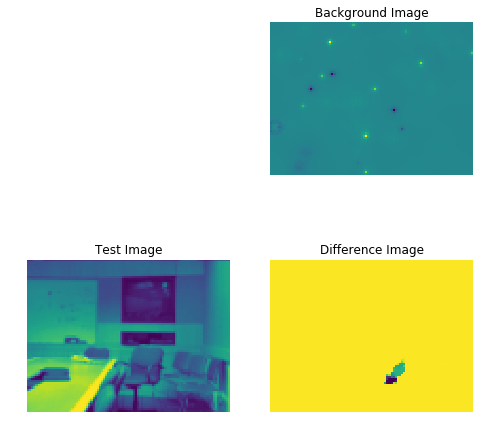

Object Detected!


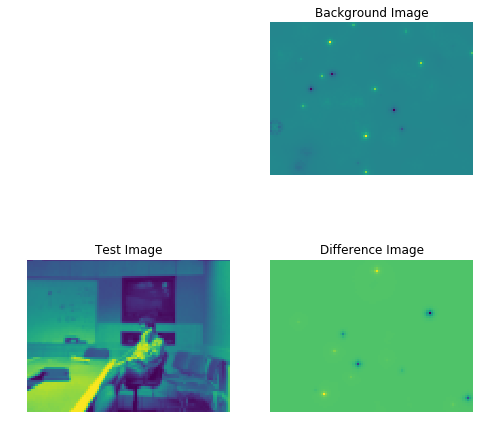

Object Detected!


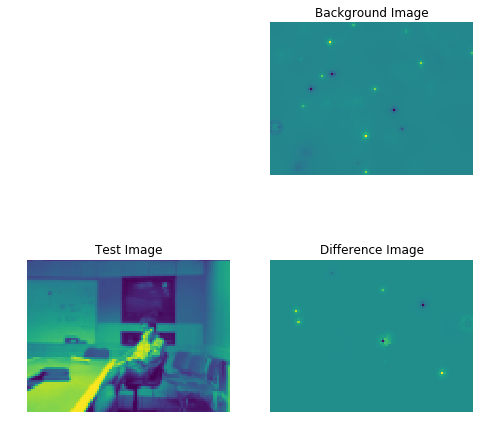

Object Detected!


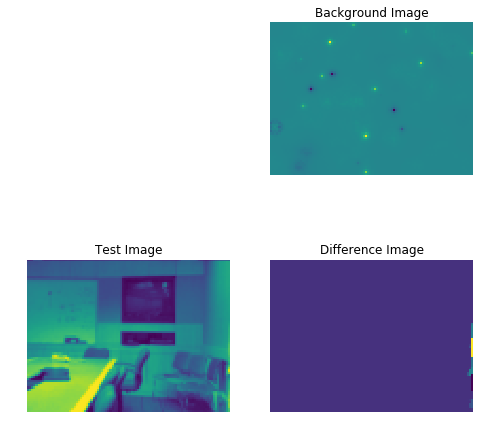

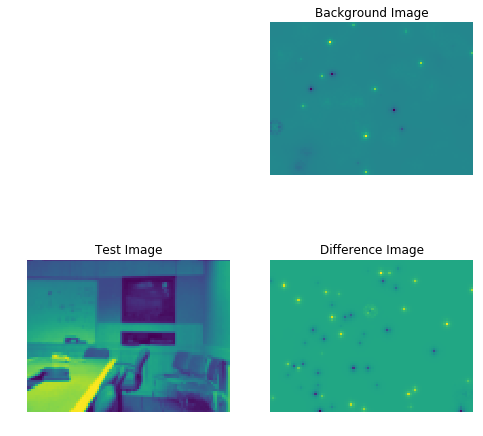

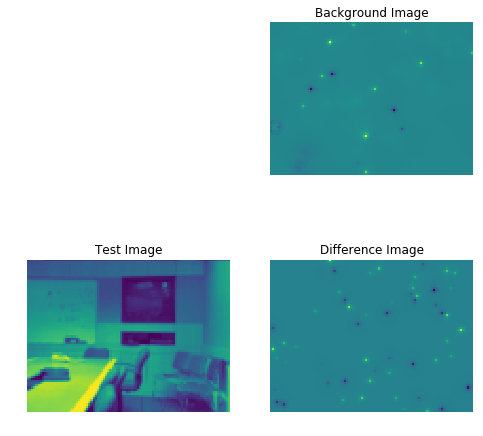

In [29]:
# We test the algorithm with the different background update possibility on various test images

img_w, img_h = x_train[0].shape
np.random.seed(10) # Setting the seed for reproductibility
idx = np.random.choice(len(x_test), 5)
print(idx) # Selection 5 test images randomly
xtest = x_test[idx]


## Measurement Rate of 50%
cls = Object_Detector(img_w, img_h, r=0.5)
model = cls.fit(x_train)
print("Measurement rate of 50%")
plt.title("Training background mean")
plt.imshow(model["x_b"])
plt.show()
cls.predict(xtest, model, rec=True, verbose=True)
cls.predict(x_train[:2], model, rec=True, verbose=True)

## Measurement Rate of 10%
cls = Object_Detector(img_w, img_h, r=0.1)
model = cls.fit(x_train)
print("Measurement rate of 10%")
plt.title("Training background mean")
plt.imshow(model["x_b"])
plt.show()
cls.predict(xtest, model, rec=True, verbose=True)
cls.predict(x_train[:2], model, rec=True, verbose=True)



Here are the results of the algorithm with a measurement rate of 50% and 10%. We first display the mean of the training background images $x_b$. Then for each randomly selected test image, we display the test image, the reconstruction of the background image for this level of measurement and the reconstruction of the foreground innovation. The two last images are training images to test if the algorithm is really working. We observe that the quality of the recovered foreground innovation is far better for the same measurement rate. This is also a confirmation of the article's hypothesis that a smaller number of samples is needed to reconstruct the difference image than the background or test images. Also, as in the articles' experiments, even with a rate as low as 10%, the algorithm manages to perfectly identify foreground innovations. The 5th image of the testing set seems to have no difference with the background training but when looking at it in high quality we observe that the right part is damaged, this is why our algorithm detects an object

# IV Background Substraction Model on the WavingTrees Dataset

[ 9 15 64 28 29]
Measurement rate of 50%


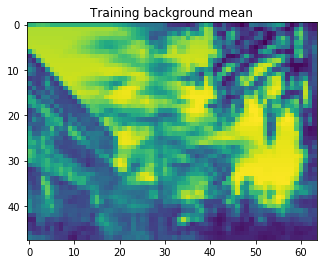

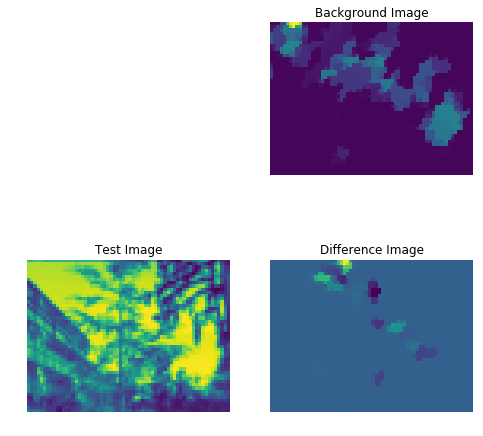

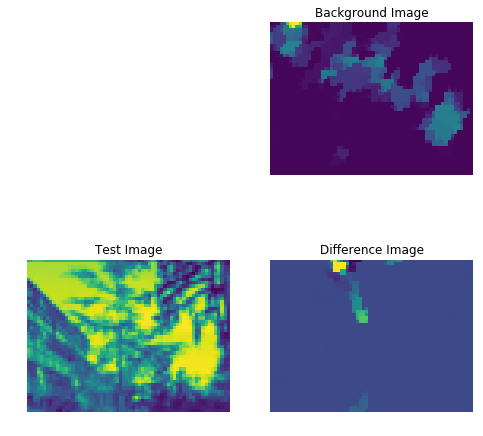

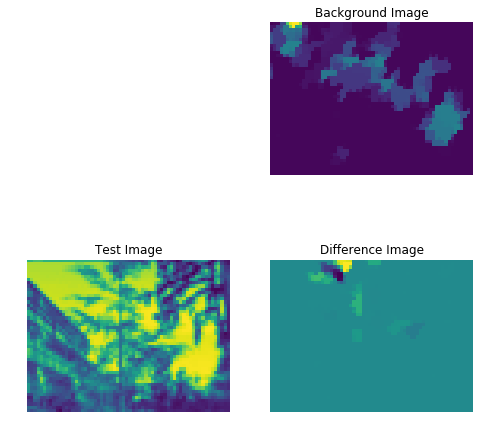

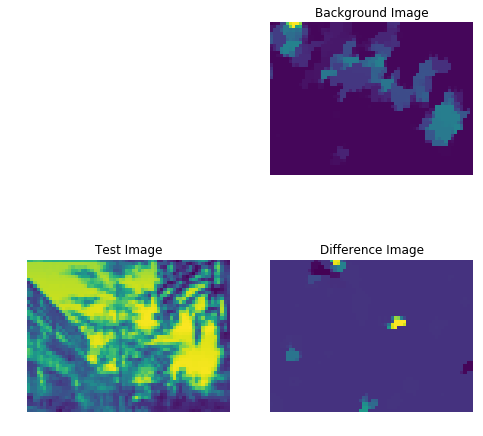

Object Detected!


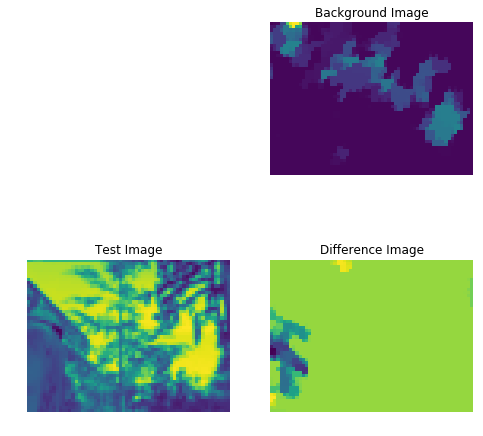

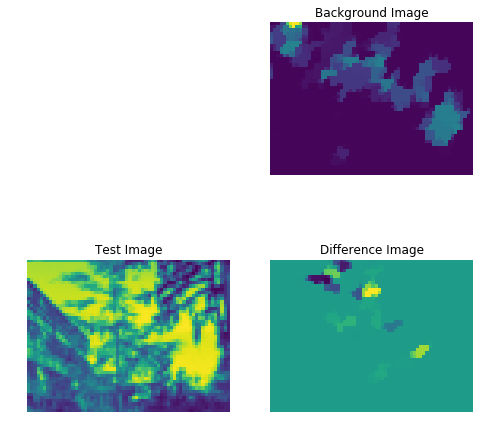

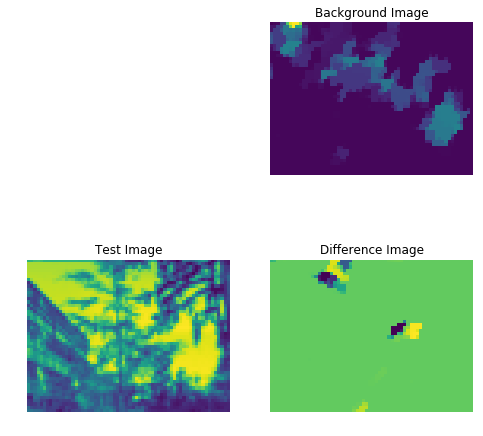

Measurement rate of 10%


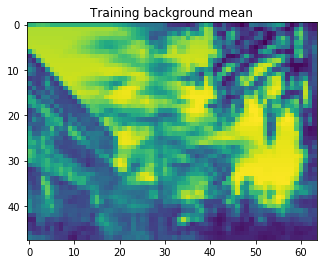

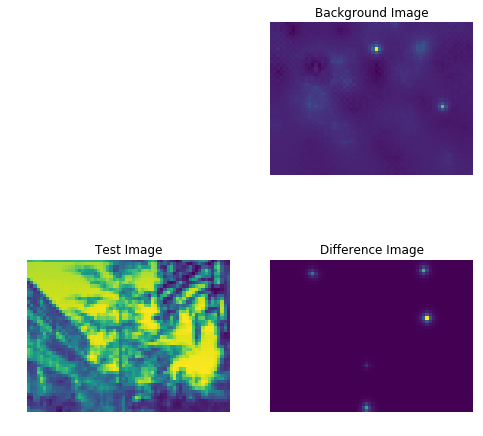

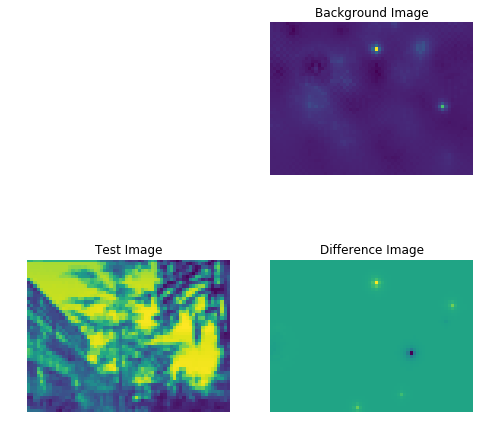

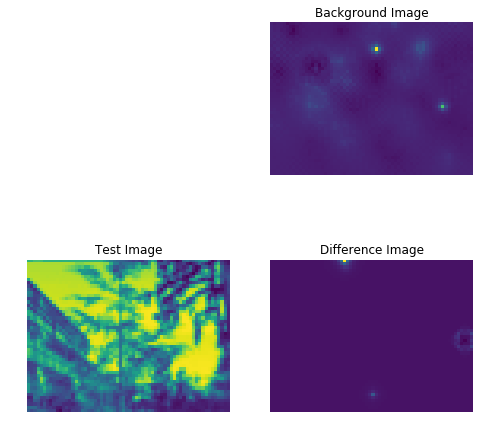

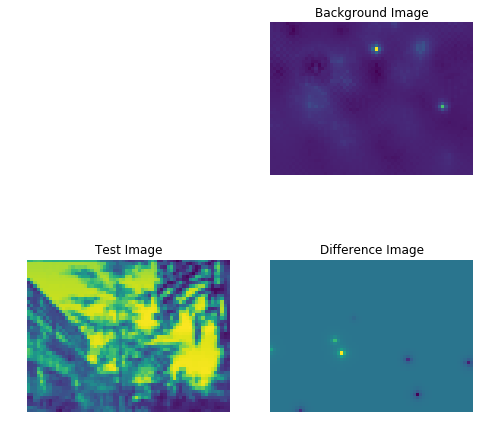

Object Detected!


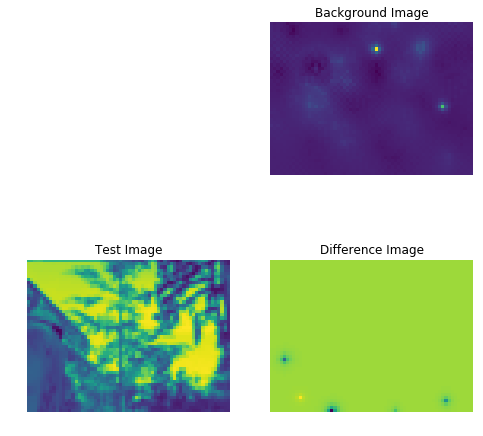

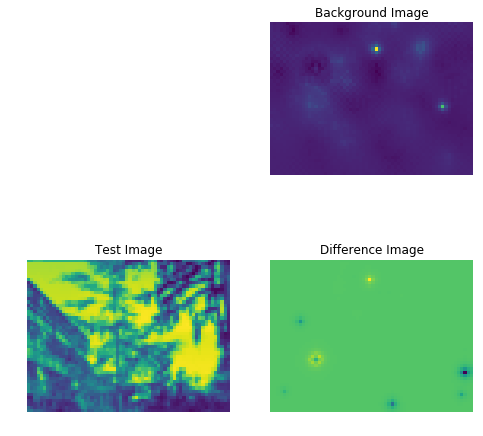

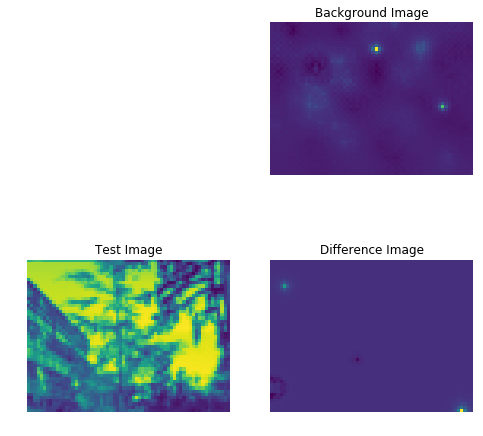

In [30]:
# Same Experiment but with another dataset

img_w, img_h = x_train_2[0].shape
np.random.seed(10) # Setting the seed for reproductibility
idx = np.random.choice(len(x_test_2), 5) 
print(idx) # Selection 5 test images randomly
xtest = x_test_2[idx]


## Measurement Rate of 50%
cls = Object_Detector(img_w, img_h, r=0.5)
model = cls.fit(x_train_2)
print("Measurement rate of 50%")
plt.title("Training background mean")
plt.imshow(model["x_b"])
plt.show()
cls.predict(xtest, model, rec=True, verbose=True)
cls.predict(x_train_2[:2], model, rec=True, verbose=True)


## Measurement Rate of 10%
cls = Object_Detector(img_w, img_h, r=0.1)
model = cls.fit(x_train_2)
print("Measurement rate of 10%")
plt.title("Training background mean")
plt.imshow(model["x_b"])
plt.show()
cls.predict(xtest, model, rec=True, verbose=True)
cls.predict(x_train_2[:2], model, rec=True, verbose=True)




Once again, our algorithm manages to detect the relevant innovation as expected.

# V Testing the background updates algorithms

For this experiment, we test the efficiency of the background updates algorithms to a background drift. In what extent is the algorithm able to adapt to permanent new background configuration?

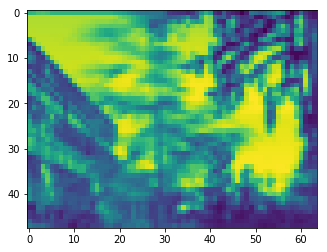

1.3683995046454367
Object Detected!


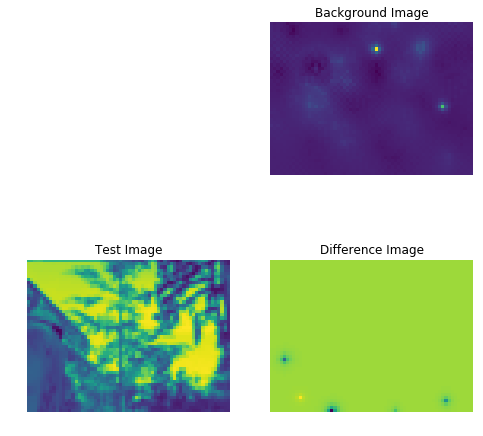

1.3683995046454367
Object Detected!


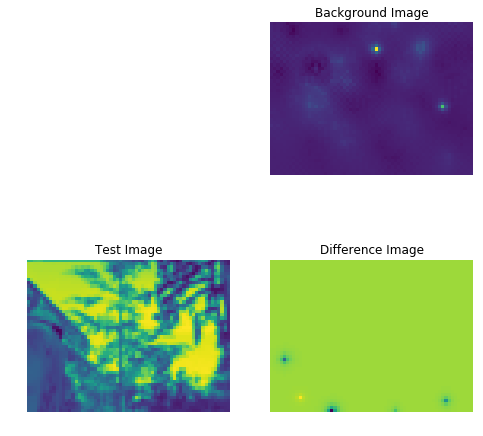

1.3683995046454367
Object Detected!


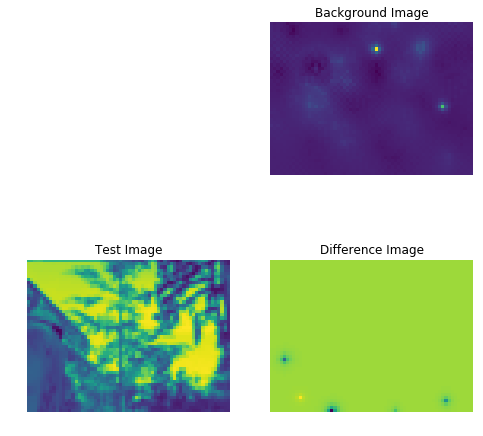

1.3683995046454367
Object Detected!


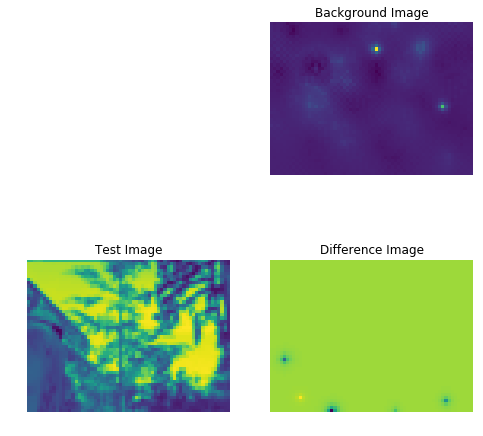

1.3683995046454367
Object Detected!


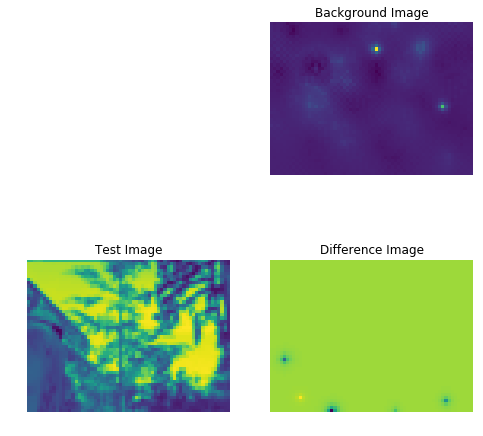

1.3683995046454367
Object Detected!


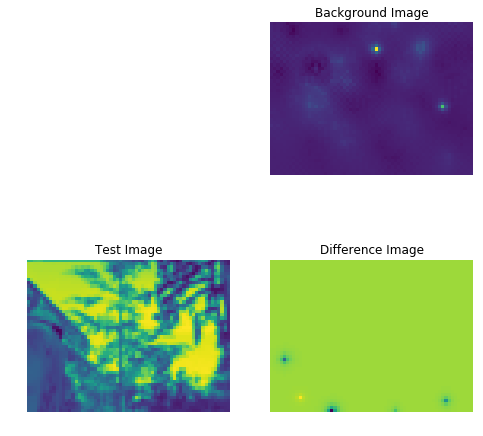

1.3683995046454367
Object Detected!


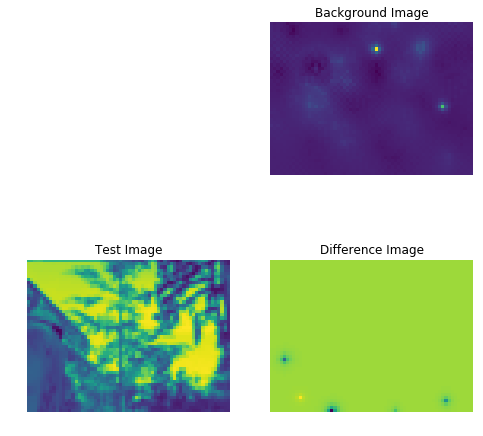

1.3683995046454367
Object Detected!


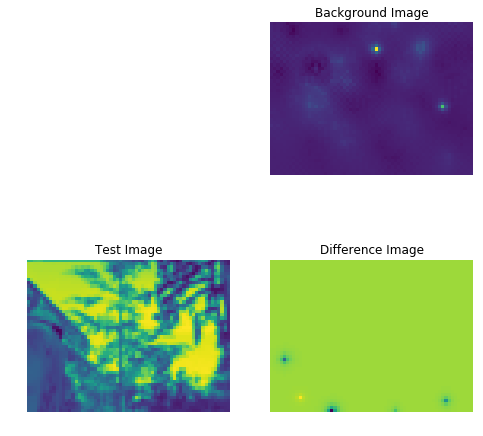

1.3683995046454367
Object Detected!


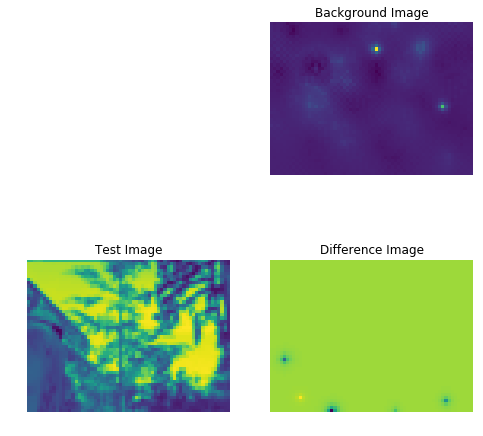

1.3683995046454367
Object Detected!


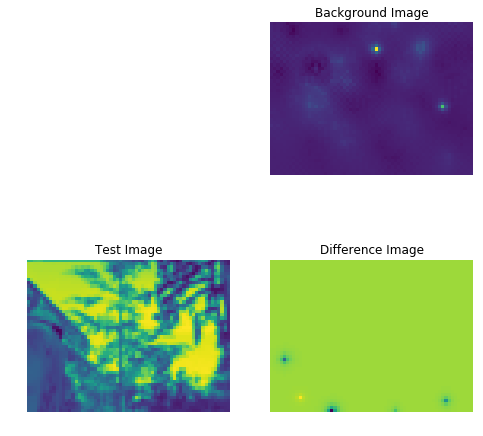

1.3683995046454367
Object Detected!


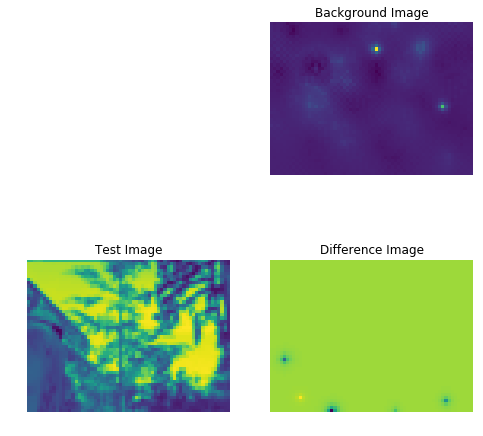

1.3683995046454367
Object Detected!


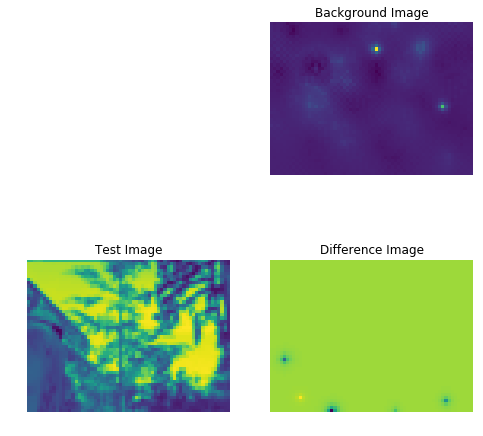

1.3683995046454367
Object Detected!


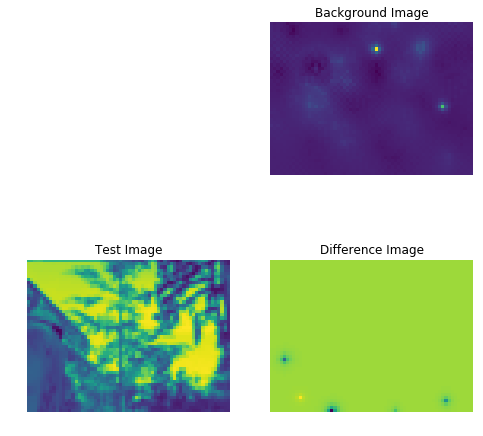

1.3683995046454367
Object Detected!


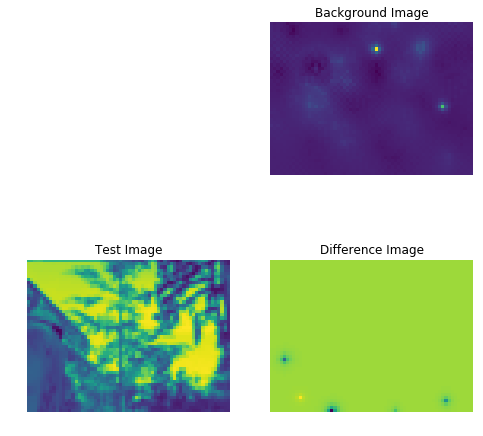

1.3683995046454367
Object Detected!


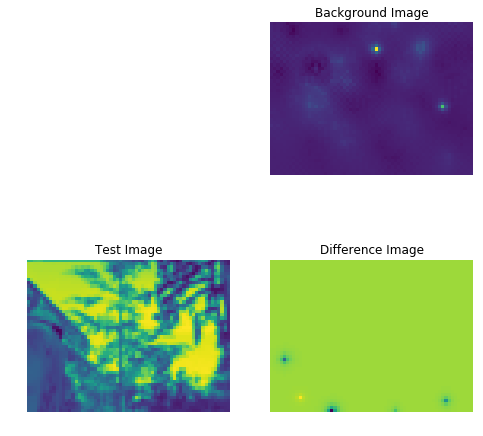

In [51]:
img_w, img_h = x_train_2[0].shape
xtest = []
for i in range(15):
    xtest.append(np.copy(x_test_2[29]))
cls = Object_Detector(img_w, img_h, r=0.1)
model = cls.fit(x_train_2)
plt.imshow(model["x_b"])
plt.show()
cls.predict(xtest, model, rec=True, backup=0, diff=True, verbose=True)

Without background update, the innnovation keeps being detected even though it is not anymore an innovation over time.

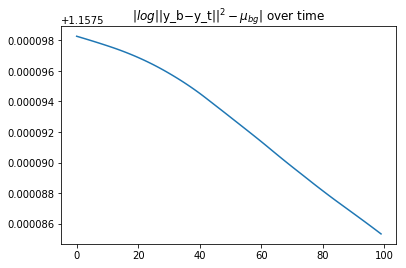

In [55]:
img_w, img_h = x_train_2[0].shape
xtest = []
for i in range(100):
    xtest.append(np.copy(x_test_2[29]))
cls = Object_Detector(img_w, img_h, r=0.01, alpha=0.0001)
model = cls.fit(x_train_2)
cls.predict(xtest, model, rec=False, backup=1)
dist = cls.distance
plt.plot(dist);
plt.title("$|log||$y_b$-$y_t$||^2-\mu_{bg}|$ over time");
plt.show();

Here, we see that the difference triggering the object detection becomes lower and lower and would eventually not anymore trigger the alert with sufficient number of frames (here only 100). 

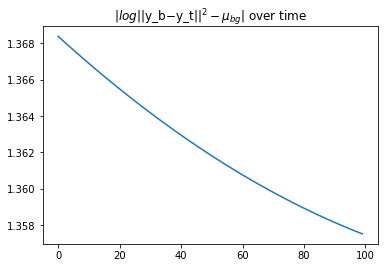

In [54]:
img_w, img_h = x_train_2[0].shape
xtest = []
for i in range(100):
    xtest.append(np.copy(x_test_2[29]))
cls = Object_Detector(img_w, img_h, r=0.1, gamma=0.1, alpha=0.0001) 
model = cls.fit(x_train_2)
cls.predict(xtest, model, rec=False, backup=2, diff=False)
dist = cls.distance
plt.plot(dist);
plt.title("$|log||$y_b$-$y_t$||^2-\mu_{bg}|$ over time");
plt.show();

With the right hyperparameters, mainly a very small alpha and a small gamma, the second background update works well. The distance is decreasing even faster than for the first update.